# Executable Jupyter notebook 2: Medical data for regression

In [1]:
# imports and plotting utility functions
%matplotlib inline
import warnings

import numpy as np
from scipy.linalg import norm
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
from statsmodels.regression.linear_model import OLS

from matplotlib import pylab as plt
import seaborn as sns

warnings.filterwarnings('ignore')

rf_cmp = RandomForestRegressor(n_estimators=250, criterion='mse', bootstrap=True, oob_score=True, random_state=0)

def plot_lr(true_coefs, est_coefs, pvals, var_names=None, rf_cmp_coef=None):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(15, 7))
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, s=150, color='red', label='estimated betas', alpha=0.5)
    if true_coefs is not None:
        plt.scatter(np.arange(X.shape[1]), true_coefs, s=150, color='black', label='true betas', alpha=0.5)
    if rf_cmp_coef is not None:
        plt.scatter(np.arange(X.shape[1]), rf_cmp_coef, s=150, marker='D', color='steelblue', label='RandomForest importances', alpha=0.5)

    # print star significant betas and their values
    axes = plt.gca()
    #import pdb; pdb.set_trace()
    y_min, y_max = axes.get_ylim()
    axes.set_ylim(y_min * 1.25, y_max * 1.25)
    sign_y = np.sum(where_sign) * [y_min]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)
    for i_b, p in enumerate(pvals):
        plt.text(x=i_b - 0.25, y=y_min * 1.10, s='$p$=%.3f' % p)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    if var_names is None:
        plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1), fontsize=16)
    else:
        plt.xticks(np.arange(n_feat), var_names, fontsize=16)
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right', fontsize=14, fancybox=True, framealpha=0.5)

def plot_regr_paths(coefs, accs, nonzeros, C_grid, var_names=None, unbiased_accs=None, metric=None):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = coefs.shape[1]

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    if var_names is None:
        X_colnames = np.arange(n_feat) + 1
    else:
        X_colnames = var_names
            
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=11, markerscale=10, fancybox=True, framealpha=0.5)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    #import pdb; pdb.set_trace()
    axarr[1].grid(True)
    if unbiased_accs is not None:
        axarr[1].scatter(np.arange(len(unbiased_accs)), unbiased_accs, color='orange',
                     linewidth=4, label='prediction accuracy (unbiased)', zorder=10)
    axarr[1].scatter(np.arange(len(accs)), accs, color='black',
                     linewidth=3, label='prediction accuracy', zorder=10)
    # axarr[1].set_title('ACCURACY')
    if metric == mean_absolute_error:
        error_title = 'LASSO: Out-of-sample performance (MAD score)'
    else:
        axarr[1].set_ylim(-0.15, 1.05)
        error_title = 'LASSO: Out-of-sample performance ($R^2$ score)'
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample performance', fontsize=16)
    axarr[1].legend(loc='lower left', fontsize=14, markerscale=1, fancybox=True, framealpha=0.5)
    axarr[1].set_title(error_title, fontsize=16)
    return my_colors
    
def corrfunc(x, y, **kws):
    from scipy import stats
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


/Users/dengeman/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import statsmodels.api as sm

# https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
def fwd_stepwise_selection(X, y, initial_list=[], verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while len(included) < X.shape[1]:
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        best_feature = new_pval.argmin()
        included.append(best_feature)
        if verbose:
            print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
    return included

In [3]:
# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid, metric=None, verbose=True):
    coef_list2 = []
    acc_list2 = []
    acc_unbiased_list2 = []
    nonzero_list2 = []
    if metric is None:
        metric = r2_score
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_accs_unbiased = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = next(iter(folder))

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = metric(
                    y_true=y[test_inds],
                    y_pred=clf.predict(X[test_inds]))
            
            # get out-of-sample accuracy from unbiased linear model with selected inputs
            b_vars_to_keep = clf.coef_ != 0
            if np.sum(b_vars_to_keep) > 0:
                unbiased_lr = LinearRegression()
                unbiased_lr.fit(
                  X[train_inds, :][:, b_vars_to_keep], y[train_inds])
                unbiased_acc = metric(
                    y_true=y[test_inds],
                    y_pred=unbiased_lr.predict(X[test_inds][:, b_vars_to_keep]))
            else:
                unbiased_acc = 0

            sample_accs.append(acc)
            sample_accs_unbiased.append(unbiased_acc)
            sample_coef.append(clf.coef_)                

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_for_C = np.mean(sample_accs)
        acc_for_C_unbaised = np.mean(sample_accs_unbiased)
        acc_list2.append(acc_for_C)
        acc_unbiased_list2.append(np.mean(sample_accs_unbiased))
        notzero = np.count_nonzero(mean_coefs)
        nonzero_list2.append(notzero)
        if verbose:
            print("alpha: %.4f acc: %.2f / %.2f (unbiased) active_coefs: %i" % (
                my_C, acc_for_C, acc_for_C_unbaised, notzero))
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2), np.array(acc_unbiased_list2)

In [4]:
def infpred_plot(unbiased_acc_list, lr_pvalues, coef_list, feat_names, acc_offset=0.1, annot_ha='center'):
    fig = plt.figure(figsize=(9, 9))
    sorter = unbiased_acc_list.argsort()[::-1]
    colors = plt.cm.viridis_r(np.linspace(0.1, 0.9, len(sorter)))

    unique_nonzero = {}
    size = 20
    for ii, idx in enumerate(sorter):
        acc = unbiased_acc_list[idx]
        non_zero = np.where(coef_list[idx])[0]
        if tuple(non_zero) not in unique_nonzero:
            unique_nonzero[tuple(non_zero)] = non_zero
        else:
            print('skipping', ii)
            continue

        xx = -np.log10(lr_pvalues[non_zero])
        this_acc = np.array([acc] * len(xx))
        size *= 0.9
        plt.plot(xx + np.random.sample(len(xx)) * 0.01,
                 this_acc,
                 marker='o', linestyle='None',
                 color=colors[ii], zorder=-ii,
                 alpha=0.9,
                 mfc='None',
                 mew=1,
                 markersize=size)
        if ii == 0:
            psorter = np.argsort(lr_pvalues)
            feat_names_ = [feat_names[kk] for kk in psorter]
            xx2 = -np.log10(lr_pvalues[psorter])
            for jj, (this_name, this_x) in enumerate(zip(feat_names_, xx2)):
                print(this_x)
                plt.annotate(
                    this_name, xy=(this_x, acc + acc_offset),
                    xycoords='data', rotation=90,
                    verticalalignment='bottom' if jj % 2 else 'top',
                    ha=annot_ha,
                    fontsize=14)
    plt.axvline(
        -np.log10(0.05), color='red', linestyle='--', linewidth=3)
    plt.annotate('p < 0.05', xy=(-np.log10(0.045), 0.03), color='red', fontsize=16)
    plt.xlabel(r'significance [$-log_{10}(p)$]', fontsize=20, fontweight=150)
    plt.ylabel(r'prediction [$R^2$]', fontsize=20, fontweight=150)
    plt.ylim(0, 1)
    plt.grid(True)
    ax = plt.gca()
    ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_yticks(np.arange(0.01, 1, 0.01), minor=True);
    return fig

# Diabetes: 2 very predictive, but only 1 significant variable

Dataset summary: Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.
(http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

In [5]:
import sklearn.datasets as ds  
bun = ds.load_diabetes()
X, y = bun.data, bun.target
X = StandardScaler().fit_transform(X)
feat_names = bun.feature_names

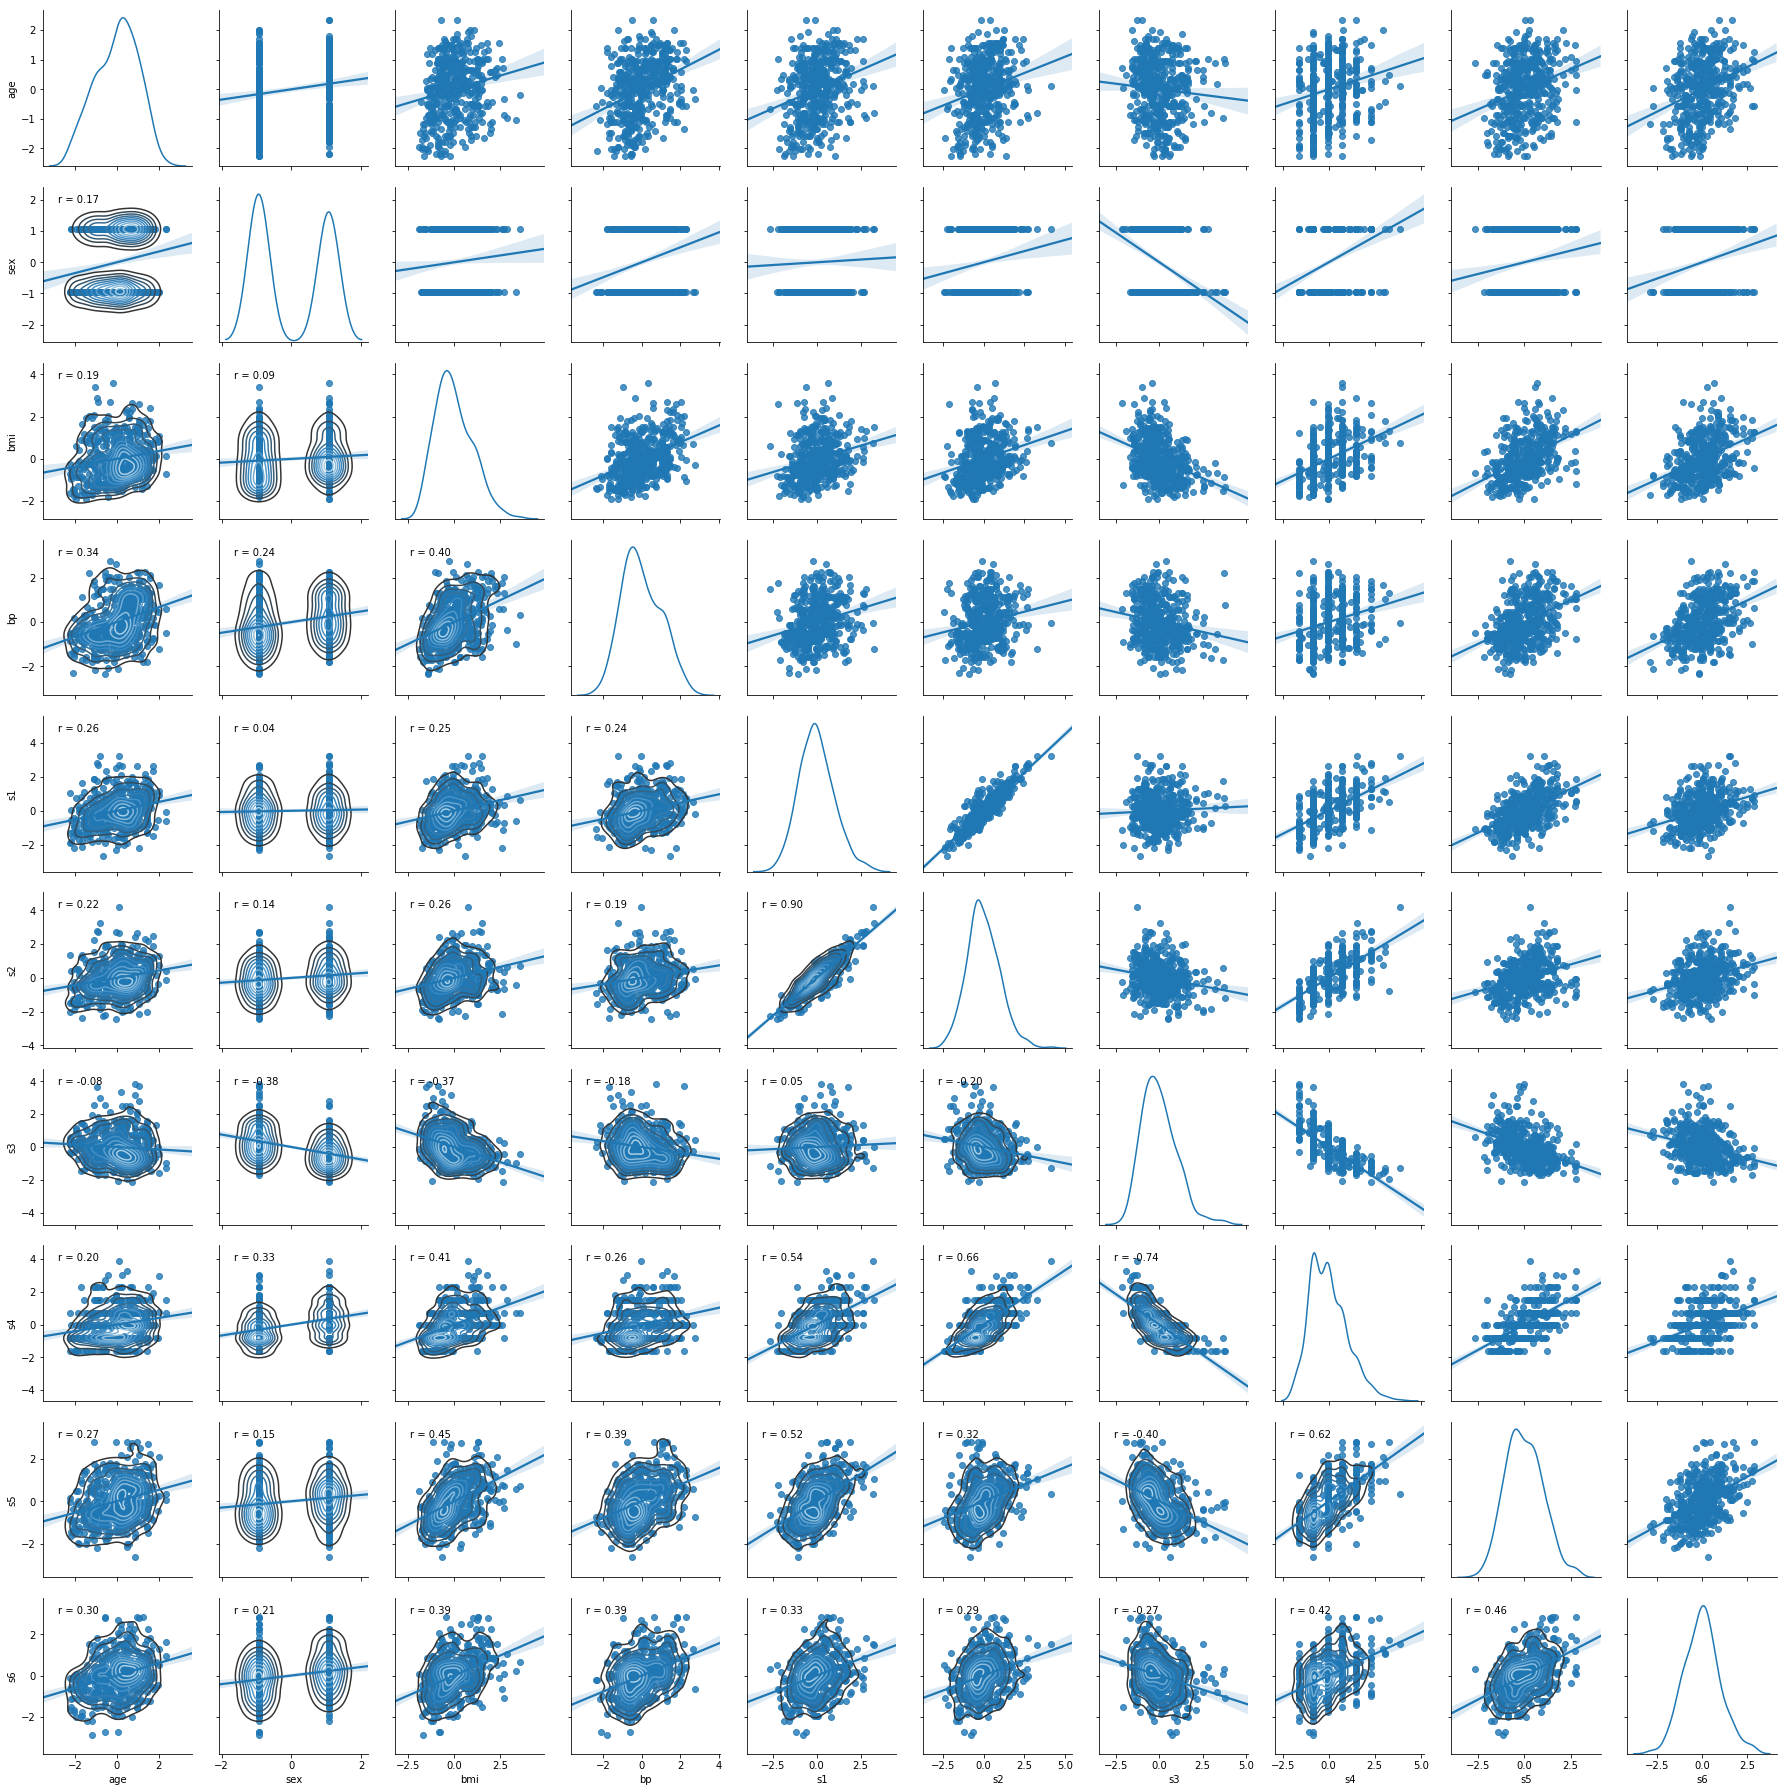

In [6]:
g = sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0004
alpha: 0.0100 acc: 0.45 / 0.45 (unbiased) active_coefs: 10
alpha: 0.0147 acc: 0.45 / 0.45 (unbiased) active_coefs: 10
alpha: 0.0215 acc: 0.45 / 0.45 (unbiased) active_coefs: 10
alpha: 0.0316 acc: 0.45 / 0.45 (unbiased) active_coefs: 10
alpha: 0.0464 acc: 0.45 / 0.45 (unbiased) active_coefs: 10
alpha: 0.0681 acc: 0.45 / 0.45 (unbiased) active_coefs: 10
alpha: 0.1000 acc: 0.46 / 0.45 (unbiased) active_coefs: 10
alpha: 0.1468 acc: 0.46 / 0.46 (unbiased) active_coefs: 10
alpha: 0.2154 acc: 0.46 / 0.45 (unbiased) active_coefs: 10
alpha: 0.3162 acc: 0.46 / 0.45 (unbiased) active_coefs: 10
alpha: 0.4642 acc: 0.46 / 0.46 (unbiased) active_coefs: 9
alpha: 0.6813 acc: 0.46 / 0.45 (unbiased) active_coefs: 9
alpha: 1.0000 acc: 0.46 / 0.45 (unbiased) active_coefs: 9
alpha: 1.4678 acc: 0.46 / 0.46 (unbiased) active_coefs: 10
alpha: 2.1544 acc: 0.46 / 0.46 (unbiased) active_coefs: 8
alpha: 3.1623 acc: 0.45 / 0.45 (unbiased) active_coefs: 8
alpha: 4.6416 acc: 0.45 / 0.45 

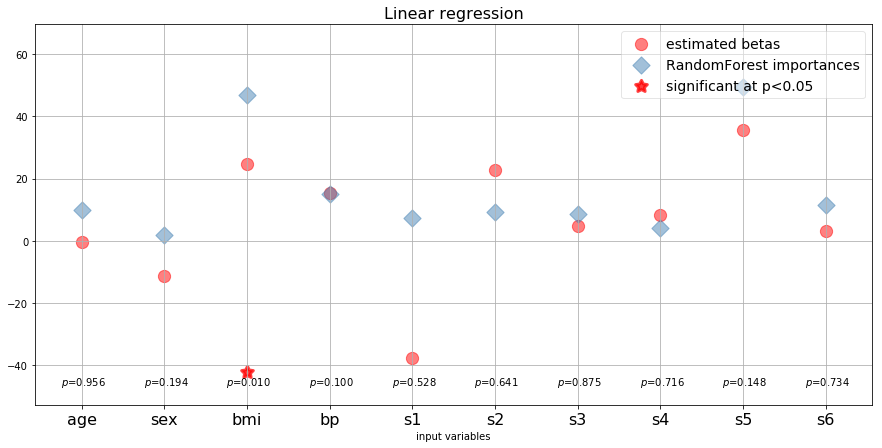

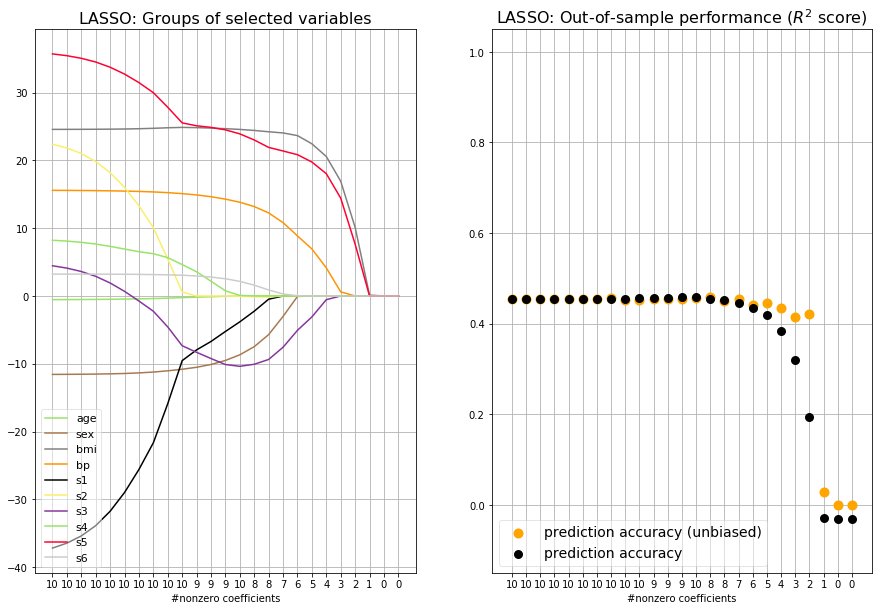

In [7]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-2, 2, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * 10 * np.mean(np.abs(lr_coefs)))
path_colors = plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

2.00836758255
0.99805835067
0.831173523726
0.711931965772
0.277160066083
0.193251734924
0.145088838637
0.134406512913
0.0581639211354
0.0196968809084
skipping 2
skipping 4
skipping 5
skipping 7
skipping 8
skipping 9
skipping 10
skipping 11
skipping 12
skipping 13
skipping 14
skipping 15
skipping 16
skipping 24


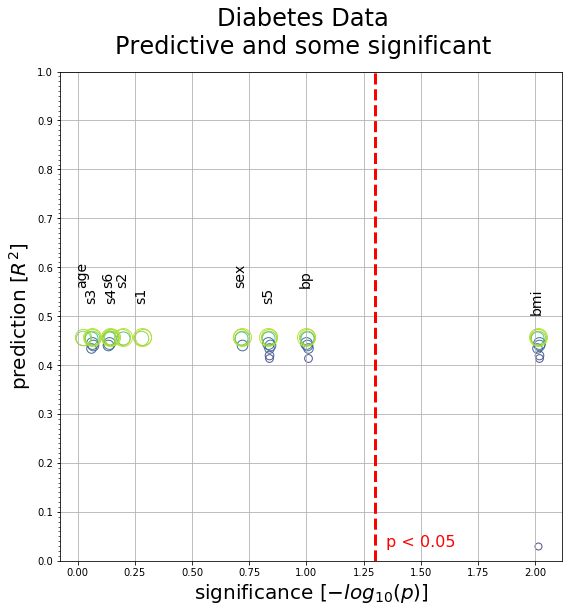

In [8]:
fig = infpred_plot(unbiased_acc_list, lr_pvalues, coef_list, feat_names)
fig.suptitle('Diabetes Data\nPredictive and some significant',
             fontsize=24, fontweight=150)
fig.savefig('reg-case1.pdf', bbox_inches='tight')

array(['#98E466', '#A7794F', 'grey', '#FF9300', '#000000', '#FBEF69',
       '#85359C', '#98E466', '#FF0030', '#CCCCCC'],
      dtype='<U7')

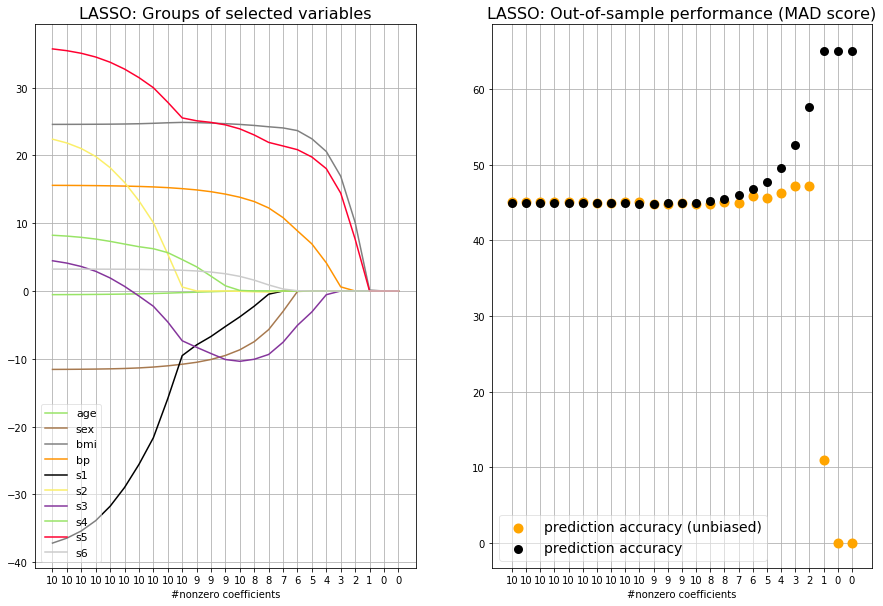

In [9]:
C_grid = np.logspace(-2, 2, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid, metric=mean_absolute_error, verbose=False)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list, metric=mean_absolute_error)

In [10]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  bmi                            with p-value 3.46601e-42
Add  s5                             with p-value 3.03968e-20
Add  bp                             with p-value 3.74192e-05
Add  s1                             with p-value 0.00145437
Add  sex                            with p-value 0.00922919
Add  s2                             with p-value 0.000272264
Add  s4                             with p-value 0.261918
Add  s6                             with p-value 0.304022
Add  s3                             with p-value 0.638562
Add  age                            with p-value 0.867
Forward-stepwise selection: bmi -> s5 -> bp -> s1 -> sex -> s2 -> s4 -> s6 -> s3 -> age


# conclusions
- only var 3 significant, prediction: this one is selected too but as predictive as var 9 and similar to 4 and 7 -> S5 is as predictive as bmi but not significant, same goes for bp and s3
- bp has a lower p-value than s5, but s5 is nevertheless more predictive than bp (partly explained by their correlation of 0.39)
- bmi is significant, but alone R2 is less 0.05 !!!!!!!!!!!!!
- some of the most correlated input variables are neither significant nor predictive

In [11]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.100
Date:                Sun, 20 May 2018   Prob (F-statistic):           4.72e-07
Time:                        17:29:08   Log-Likelihood:                -2873.9
No. Observations:                 442   AIC:                             5768.
Df Residuals:                     432   BIC:                             5809.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4762      8.560     -0.056      0.956     -17.301      16.348
sex          -11.4070      8.771     -1.301      0.194     -28.647       5.832
bmi           24.7263      9.532      2.594      0.010       5.991      43.461
bp            15.4297      9.373      1.646      0.100      -2.992      33.852
s1           -37.6804     59.697     -0.631      0.528    -155.014      79.653
s2            22.6765     48.573      0.467      0.641     -72.792     118.145
s3             4.8062     30.449      0.158      0.875     -55.041      64.653
s4             8.4221     23.134      0.364      0.716     -37.048      53.892
s5            35.7347     24.628      1.451      0.148     -12.671      84.140
s6             3.2166      9.453      0.340      0.734     -15.364      21.797
==============================================================================
Omnibus:                        1.506   Durbin-Watson:                   0.223
Prob(Omnibus):                  0.471   Jarque-Bera (JB):                1.404
Skew:                           0.017   Prob(JB):                        0.496
Kurtosis:                       2.726   Cond. No.                         21.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Prostata dataset: not significant, but predictive

Prostate Cancer Data
Description
These data come from a study that examined the correlation between the level of prostate specific antigen and a number of clinical measures in men who were about to receive a radical prostatectomy. It is data frame with 97 rows and 9 columns.

Usage
data(Prostate)
Format
The data frame has the following components:

lcavol
log(cancer volume)
lweight
log(prostate weight)
age
age
lbph
log(benign prostatic hyperplasia amount)
svi
seminal vesicle invasion
lcp
log(capsular penetration)
gleason
Gleason score
pgg45
percentage Gleason scores 4 or 5
lpsa
log(prostate specific antigen)
Source
Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989)
Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, Journal of Urology 141(5), 1076–1083.

Lasso paths from Hastie et al. 2001

![image.png](attachment:image.png)

In [12]:
import pandas as pd
df_prostate = pd.read_csv('dataset_prostate.csv')
y = df_prostate['lpsa']
feat_names = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
X = StandardScaler().fit_transform(df_prostate[feat_names])

In [13]:
df_prostate

,Unnamed: 0,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564
5,6,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468
6,7,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,0.765468
7,8,0.693147,3.539509,58,1.536867,0,-1.386294,6,0,0.854415
8,9,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0,1.047319
9,10,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0,1.047319


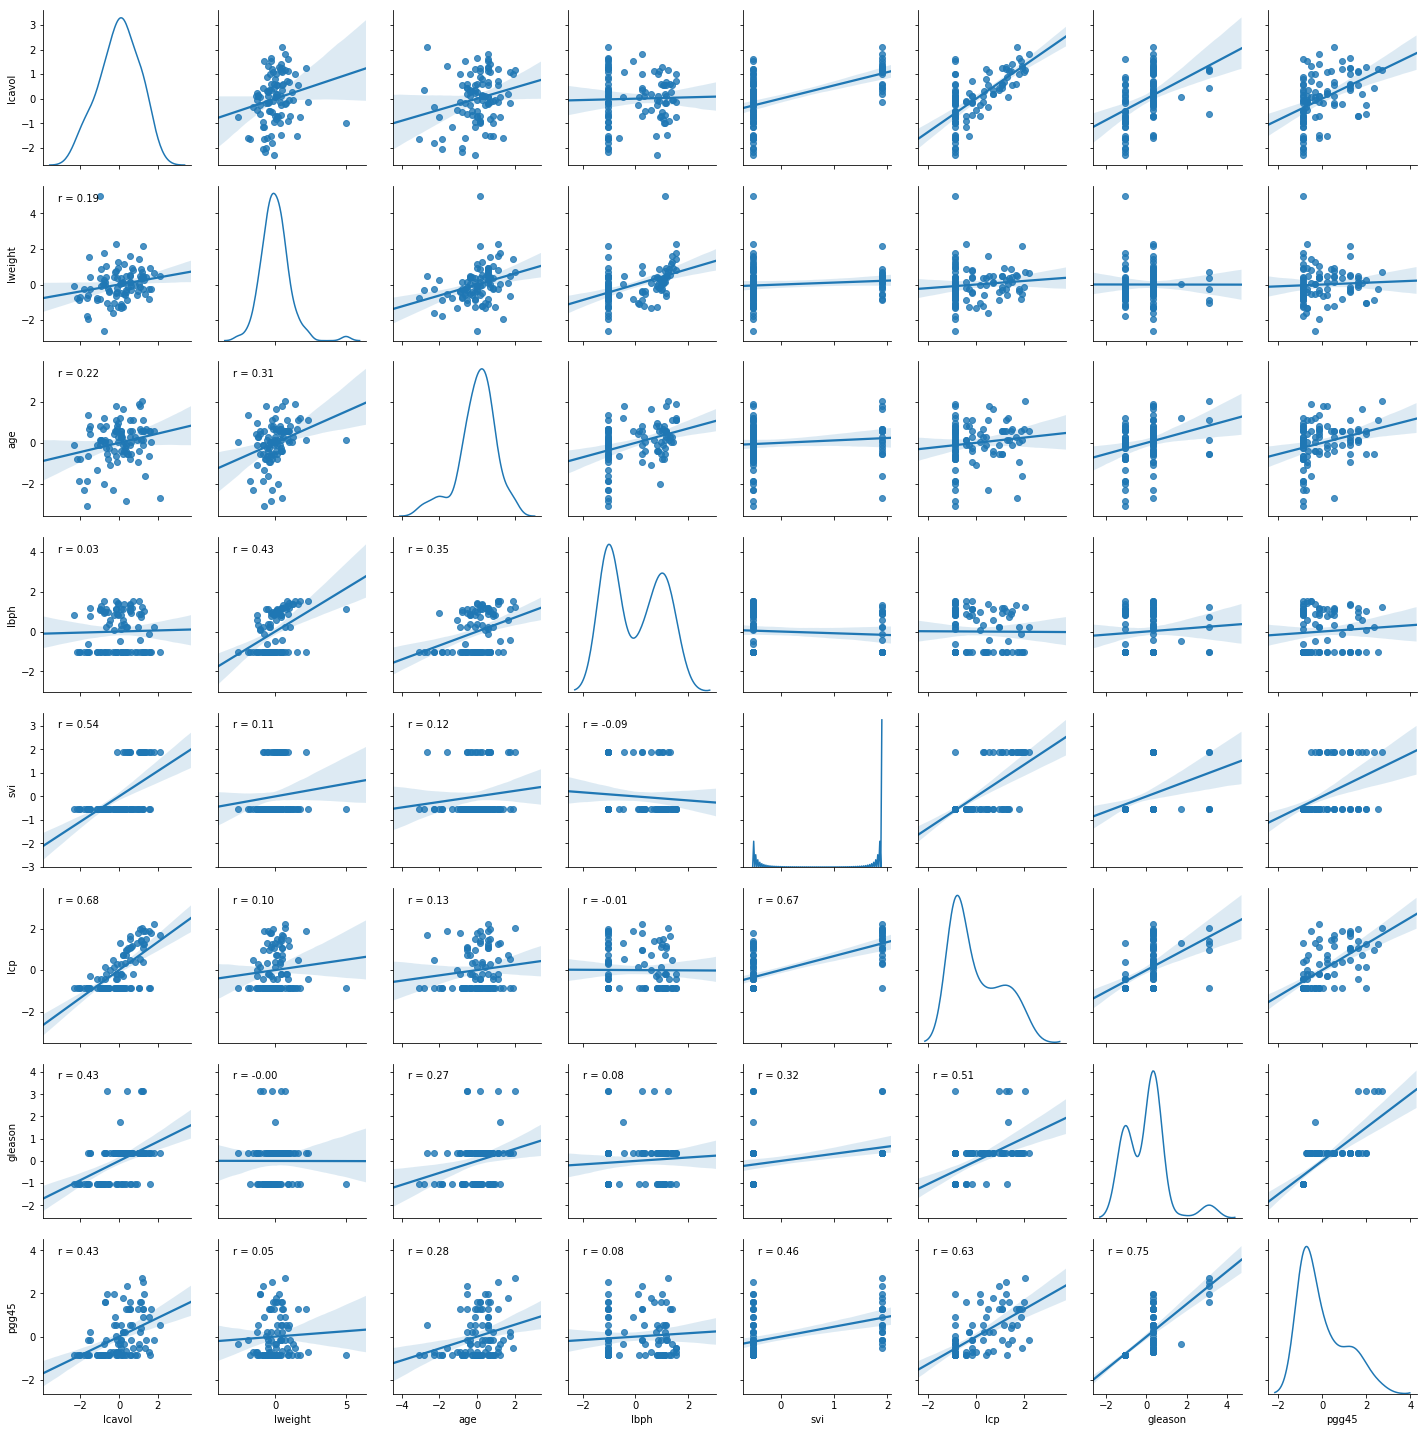

In [14]:
g = sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0011
alpha: 0.0001 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0002 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0002 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0003 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0005 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0008 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0012 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0017 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0026 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0039 acc: 0.42 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0059 acc: 0.43 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0089 acc: 0.43 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0133 acc: 0.43 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0200 acc: 0.43 / 0.41 (unbiased) active_coefs: 8
alpha: 0.0301 acc: 0.43 / 0.42 (unbiased) active_coefs: 8
alpha: 0.0453 acc: 0.43 / 0.41 (unbiased) active_coefs: 7
alpha: 0.0681 acc: 0.44 / 0.41 (unbiased) 

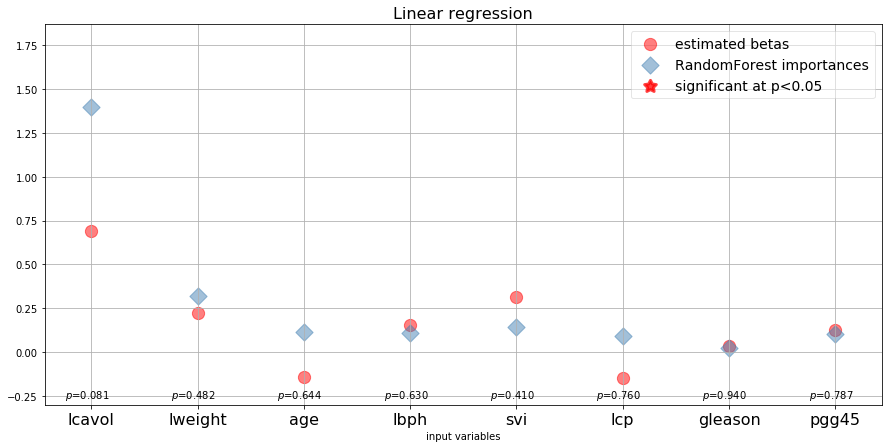

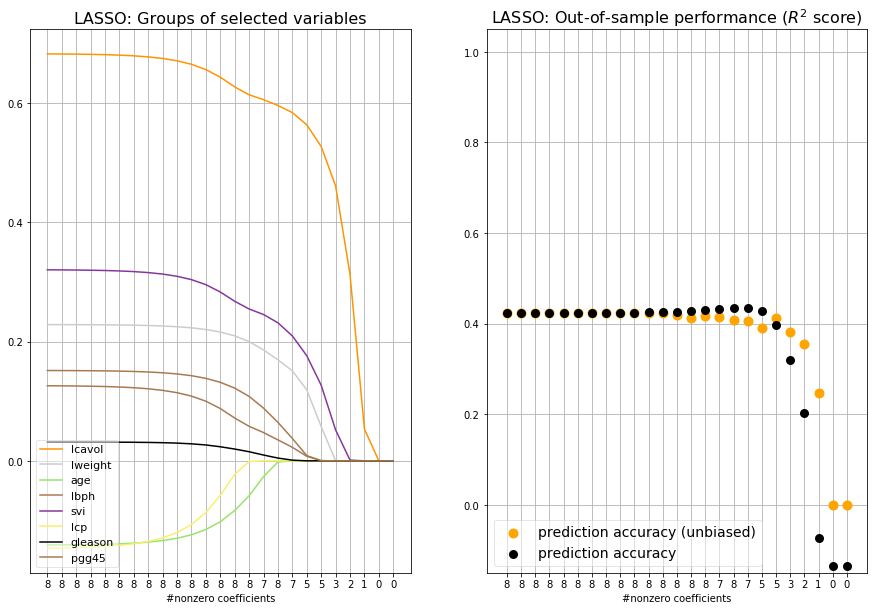

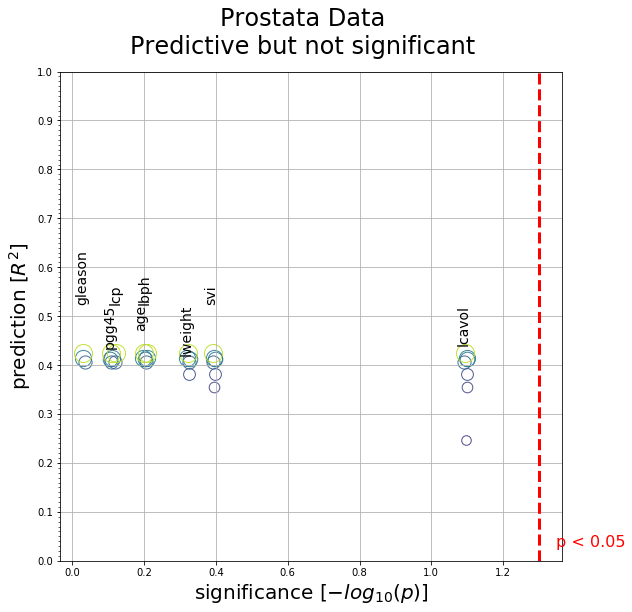

In [15]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * 10 * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

 
fig = infpred_plot(unbiased_acc_list, lr_pvalues, coef_list, feat_names)
fig.suptitle('Prostata Data\nPredictive but not significant',
             fontsize=24, fontweight=150)
fig.savefig('reg-case2.pdf', bbox_inches='tight')

array(['#FF9300', '#CCCCCC', '#98E466', '#A7794F', '#85359C', '#FBEF69',
       '#000000', '#A7794F'],
      dtype='<U7')

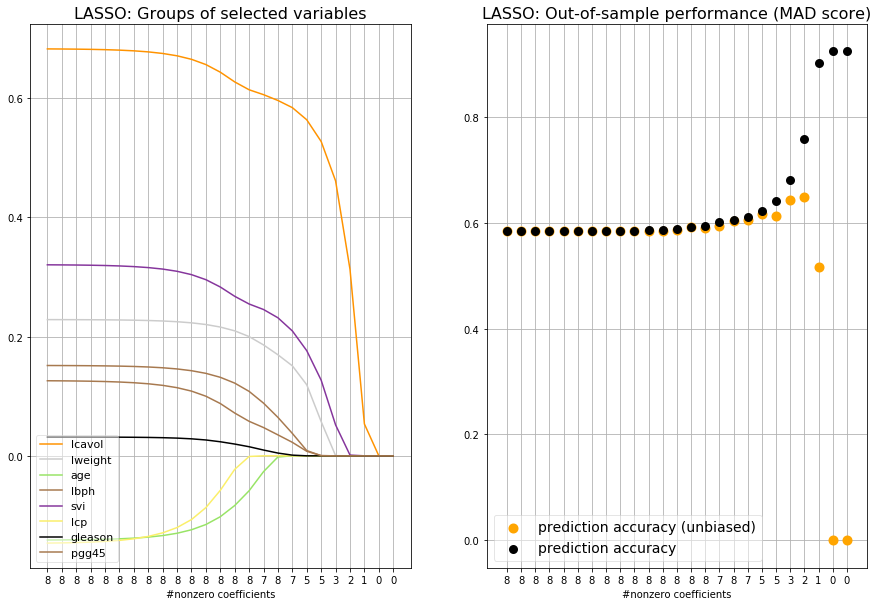

In [16]:
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid, metric=mean_absolute_error, verbose=False)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list, metric=mean_absolute_error)

In [17]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  lcavol                         with p-value 1.11861e-17
Add  lweight                        with p-value 0.00160649
Add  svi                            with p-value 0.00202903
Add  lbph                           with p-value 0.11213
Add  age                            with p-value 0.169527
Add  pgg45                          with p-value 0.253309
Add  lcp                            with p-value 0.251271
Add  gleason                        with p-value 0.77506
Forward-stepwise selection: lcavol -> lweight -> svi -> lbph -> age -> pgg45 -> lcp -> gleason


# conclusions:
- no significants (trending significant at 0.08 is also single most predictive variable)
- ~5 items not full set of 9 variables were clearly very predictive -> the widely practiced Gleason score (?) comes up as disturbing prediction
- second-most important variable diverged in fwd-stepwise selection and Lasso selection -> tiny difference

In [18]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lpsa   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.456
Date:                Sun, 20 May 2018   Prob (F-statistic):              0.185
Time:                        17:29:40   Log-Likelihood:                -229.14
No. Observations:                  97   AIC:                             474.3
Df Residuals:                      89   BIC:                             494.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         0.6883      0.390      1.764      0.081      -0.087       1.464
lweight        0.2245      0.318      0.706      0.482      -0.407       0.856
age           -0.1454      0.313     -0.464      0.644      -0.768       0.477
lbph           0.1545      0.319      0.484      0.630      -0.480       0.789
svi            0.3155      0.381      0.828      0.410      -0.441       1.072
lcp           -0.1467      0.479     -0.306      0.760      -1.099       0.805
gleason        0.0324      0.428      0.076      0.940      -0.818       0.883
pgg45          0.1270      0.470      0.270      0.787      -0.806       1.060
==============================================================================
Omnibus:                        0.235   Durbin-Watson:                   0.104
Prob(Omnibus):                  0.889   Jarque-Bera (JB):                0.026
Skew:                          -0.017   Prob(JB):                        0.987
Kurtosis:                       3.073   Cond. No.                         4.12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# FEV: significant but largely ignorable for prediction

In [19]:
import pandas as pd
df_fev = pd.read_csv('dataset_FEV.csv')

df_fev.drop(labels='id', axis=1, inplace=True)

In [20]:
df_fev

,age,fev,height,sex,smoke
0,9,1.708,57.0,female,non-current smoker
1,8,1.724,67.5,female,non-current smoker
2,7,1.720,54.5,female,non-current smoker
3,9,1.558,53.0,male,non-current smoker
4,9,1.895,57.0,male,non-current smoker
5,8,2.336,61.0,female,non-current smoker
6,6,1.919,58.0,female,non-current smoker
7,6,1.415,56.0,female,non-current smoker
8,8,1.987,58.5,female,non-current smoker
9,9,1.942,60.0,female,non-current smoker


In [21]:
feat_names = ['age', u'fev', u'height', u'sex', u'smoke']
df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_fev[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_fev[feat_names[-2:]], drop_first=True)
#pd.concat([df_part1, df_part2], axis=1)
y = StandardScaler().fit_transform(df_part1['fev'].values[:, None])[:, 0]
df_part1.drop(labels='fev', axis=1, inplace=True)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)


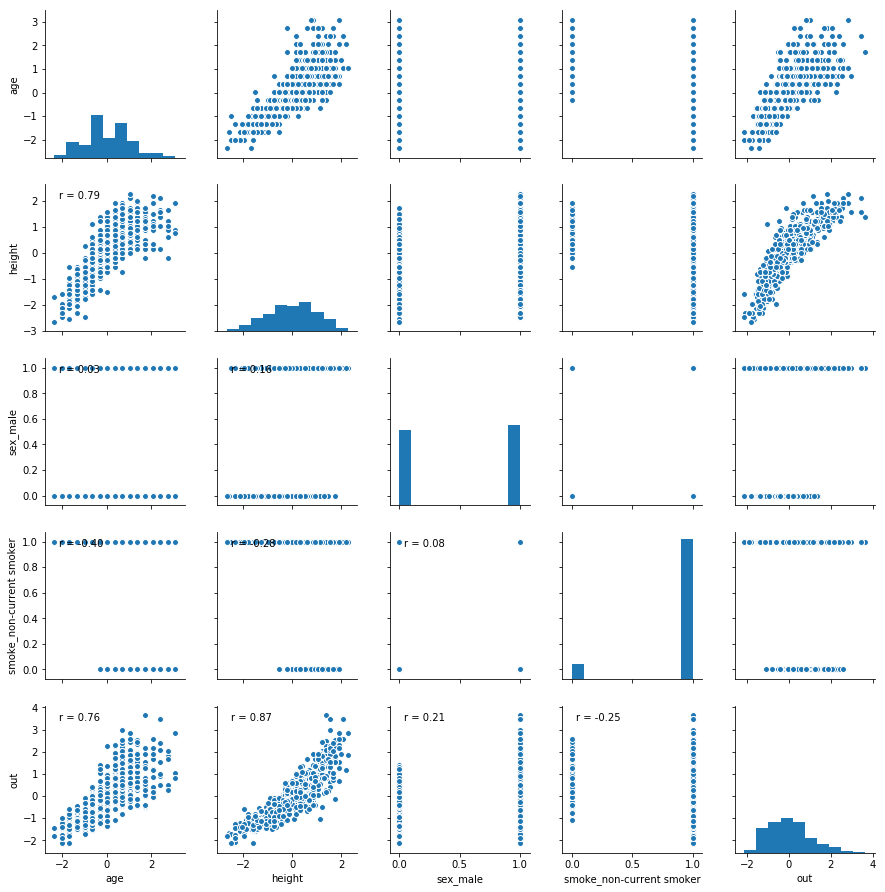

In [22]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']))
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0037
alpha: 0.0001 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0002 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0002 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0003 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0005 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0008 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0012 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0017 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0026 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0039 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0059 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0089 acc: 0.76 / 0.76 (unbiased) active_coefs: 4
alpha: 0.0133 acc: 0.76 / 0.76 (unbiased) active_coefs: 3
alpha: 0.0200 acc: 0.76 / 0.76 (unbiased) active_coefs: 3
alpha: 0.0301 acc: 0.76 / 0.76 (unbiased) active_coefs: 3
alpha: 0.0453 acc: 0.75 / 0.75 (unbiased) active_coefs: 3
alpha: 0.0681 acc: 0.75 / 0.75 (unbiased) 

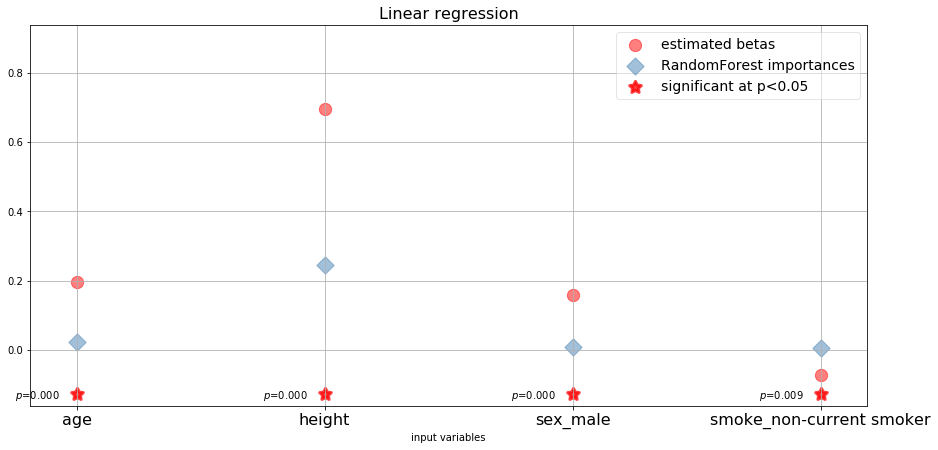

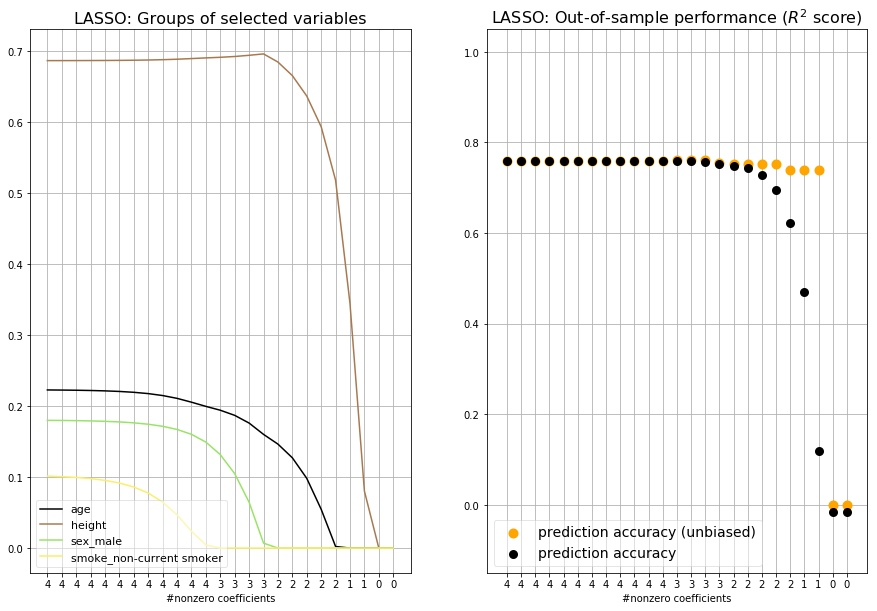

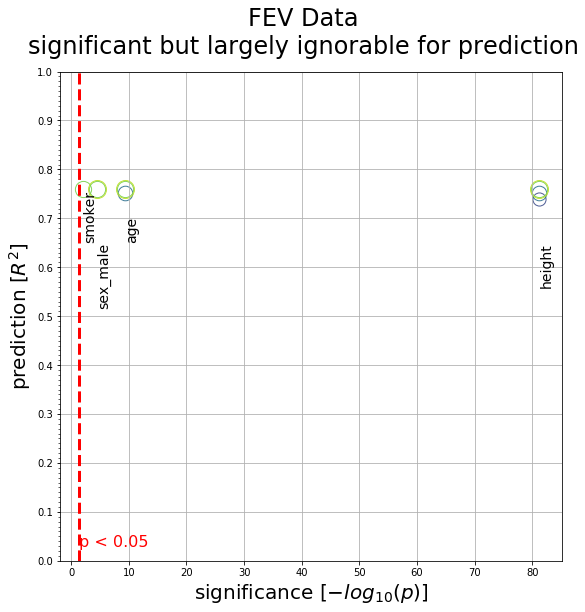

In [23]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
path_colors = plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

fig = infpred_plot(unbiased_acc_list, lr_pvalues, coef_list, feat_names[:-1] + ['smoker'],
                   -0.11, annot_ha='left')
fig.suptitle('FEV Data\nsignificant but largely ignorable for prediction',
             fontsize=24, fontweight=150)
fig.savefig('reg-case3.pdf', bbox_inches='tight')

array(['#000000', '#A7794F', '#98E466', '#FBEF69'],
      dtype='<U7')

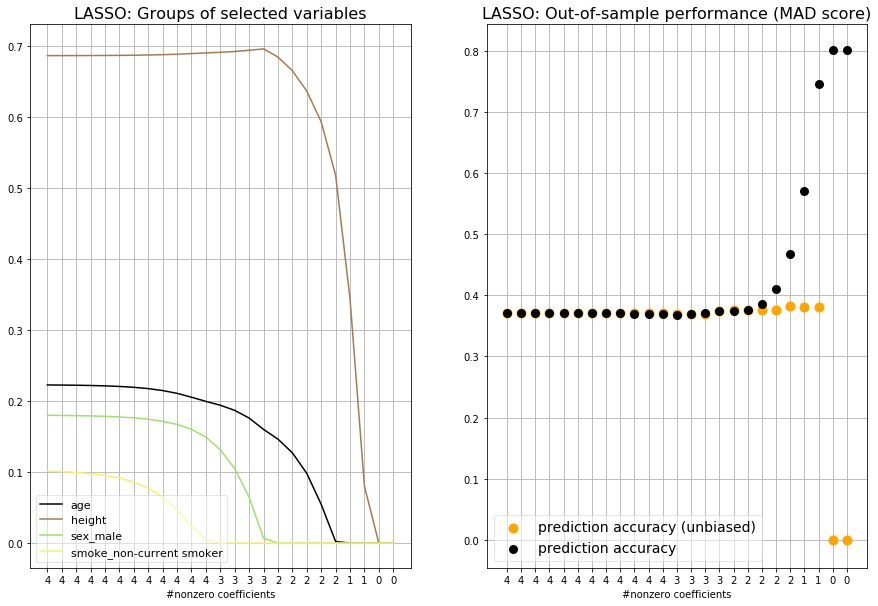

In [24]:
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid, metric=mean_absolute_error, verbose=False)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list, metric=mean_absolute_error)

In [25]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  height                         with p-value 1.57456e-200
Add  age                            with p-value 4.11176e-09
Add  sex_male                       with p-value 1.4463e-06
Add  smoke_non-current smoker       with p-value 0.141391
Forward-stepwise selection: height -> age -> sex_male -> smoke_non-current smoker


# conclusions:

- 4/4 input variables are highly significant, but height alone (ignoring other 3 variables) has virtually identical accuracy in predicting FEV
- the prediction regime may miss the significant mechanistic relevance of smoking -> predictive algorithms are much more pragmatic
- high significance of all input variables is partly due to comparably high sample sizes facilitating low p values
- scientific knowledge production / scientific discovery recovers the ground truth (all 4 variables are important)
- intensive care unit: the medical doctor wants to know what to do next with the respiration machine (=prediction)

In [26]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     552.3
Date:                Sun, 20 May 2018   Prob (F-statistic):          2.10e-207
Time:                        17:29:53   Log-Likelihood:                -443.60
No. Observations:                 654   AIC:                             895.2
Df Residuals:                     650   BIC:                             913.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                          0.1946      0.031      6.313      0.000       0.134       0.255
height                       0.6953      0.031     22.245      0.000       0.634       0.757
sex_male                     0.1575      0.038      4.193      0.000       0.084       0.231
smoke_non-current smoker    -0.0735      0.028     -2.602      0.009      -0.129      -0.018
==============================================================================
Omnibus:                       25.938   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.330
Skew:                           0.192   Prob(JB):                     5.86e-13
Kurtosis:                       4.386   Cond. No.                         3.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Low birth weight: significant, but hard to predict

Dataset description (R community): The birthwt data frame has 189 rows and 10 columns. The data were collected at Baystate Medical Center, Springfield, Mass during 1986.

low
indicator of birth weight less than 2.5 kg.

age
mother's age in years.

lwt
mother's weight in pounds at last menstrual period.

race
mother's race (1 = white, 2 = black, 3 = other).

smoke
smoking status during pregnancy.

ptl
number of previous premature labours.

ht
history of hypertension.

ui
presence of uterine irritability.

ftv
number of physician visits during the first trimester.

bwt
birth weight in grams.

Source
Hosmer, D.W. and Lemeshow, S. (1989) Applied Logistic Regression. New York: Wiley

References
Venables, W. N. and Ripley, B. D. (2002) Modern Applied Statistics with S. Fourth edition. Springer.

In [27]:
import pandas as pd
df_birth = pd.read_csv('dataset_birthwt.csv')

In [28]:
df_part1 = StandardScaler().fit_transform(df_birth[['age', 'lwt']])
df_part2 = df_birth[['race', 'smoke', 'ptl', 'ht', 'ui', 'ftv']]
#pd.concat([df_part1, df_part2], axis=1)
feat_names = ['age', 'lwt'] + list(df_part2.columns)
y = StandardScaler().fit_transform(df_birth['bwt'].values[:, None])[:, 0]
X = np.hstack((df_part1, df_part2))


In [29]:
df_birth

,Unnamed: 0,low,age,lwt,race,smoke,ptl,ht,ui,ftv,bwt
0,85,0,19,182,2,0,0,0,1,0,2523
1,86,0,33,155,3,0,0,0,0,3,2551
2,87,0,20,105,1,1,0,0,0,1,2557
3,88,0,21,108,1,1,0,0,1,2,2594
4,89,0,18,107,1,1,0,0,1,0,2600
5,91,0,21,124,3,0,0,0,0,0,2622
6,92,0,22,118,1,0,0,0,0,1,2637
7,93,0,17,103,3,0,0,0,0,1,2637
8,94,0,29,123,1,1,0,0,0,1,2663
9,95,0,26,113,1,1,0,0,0,0,2665


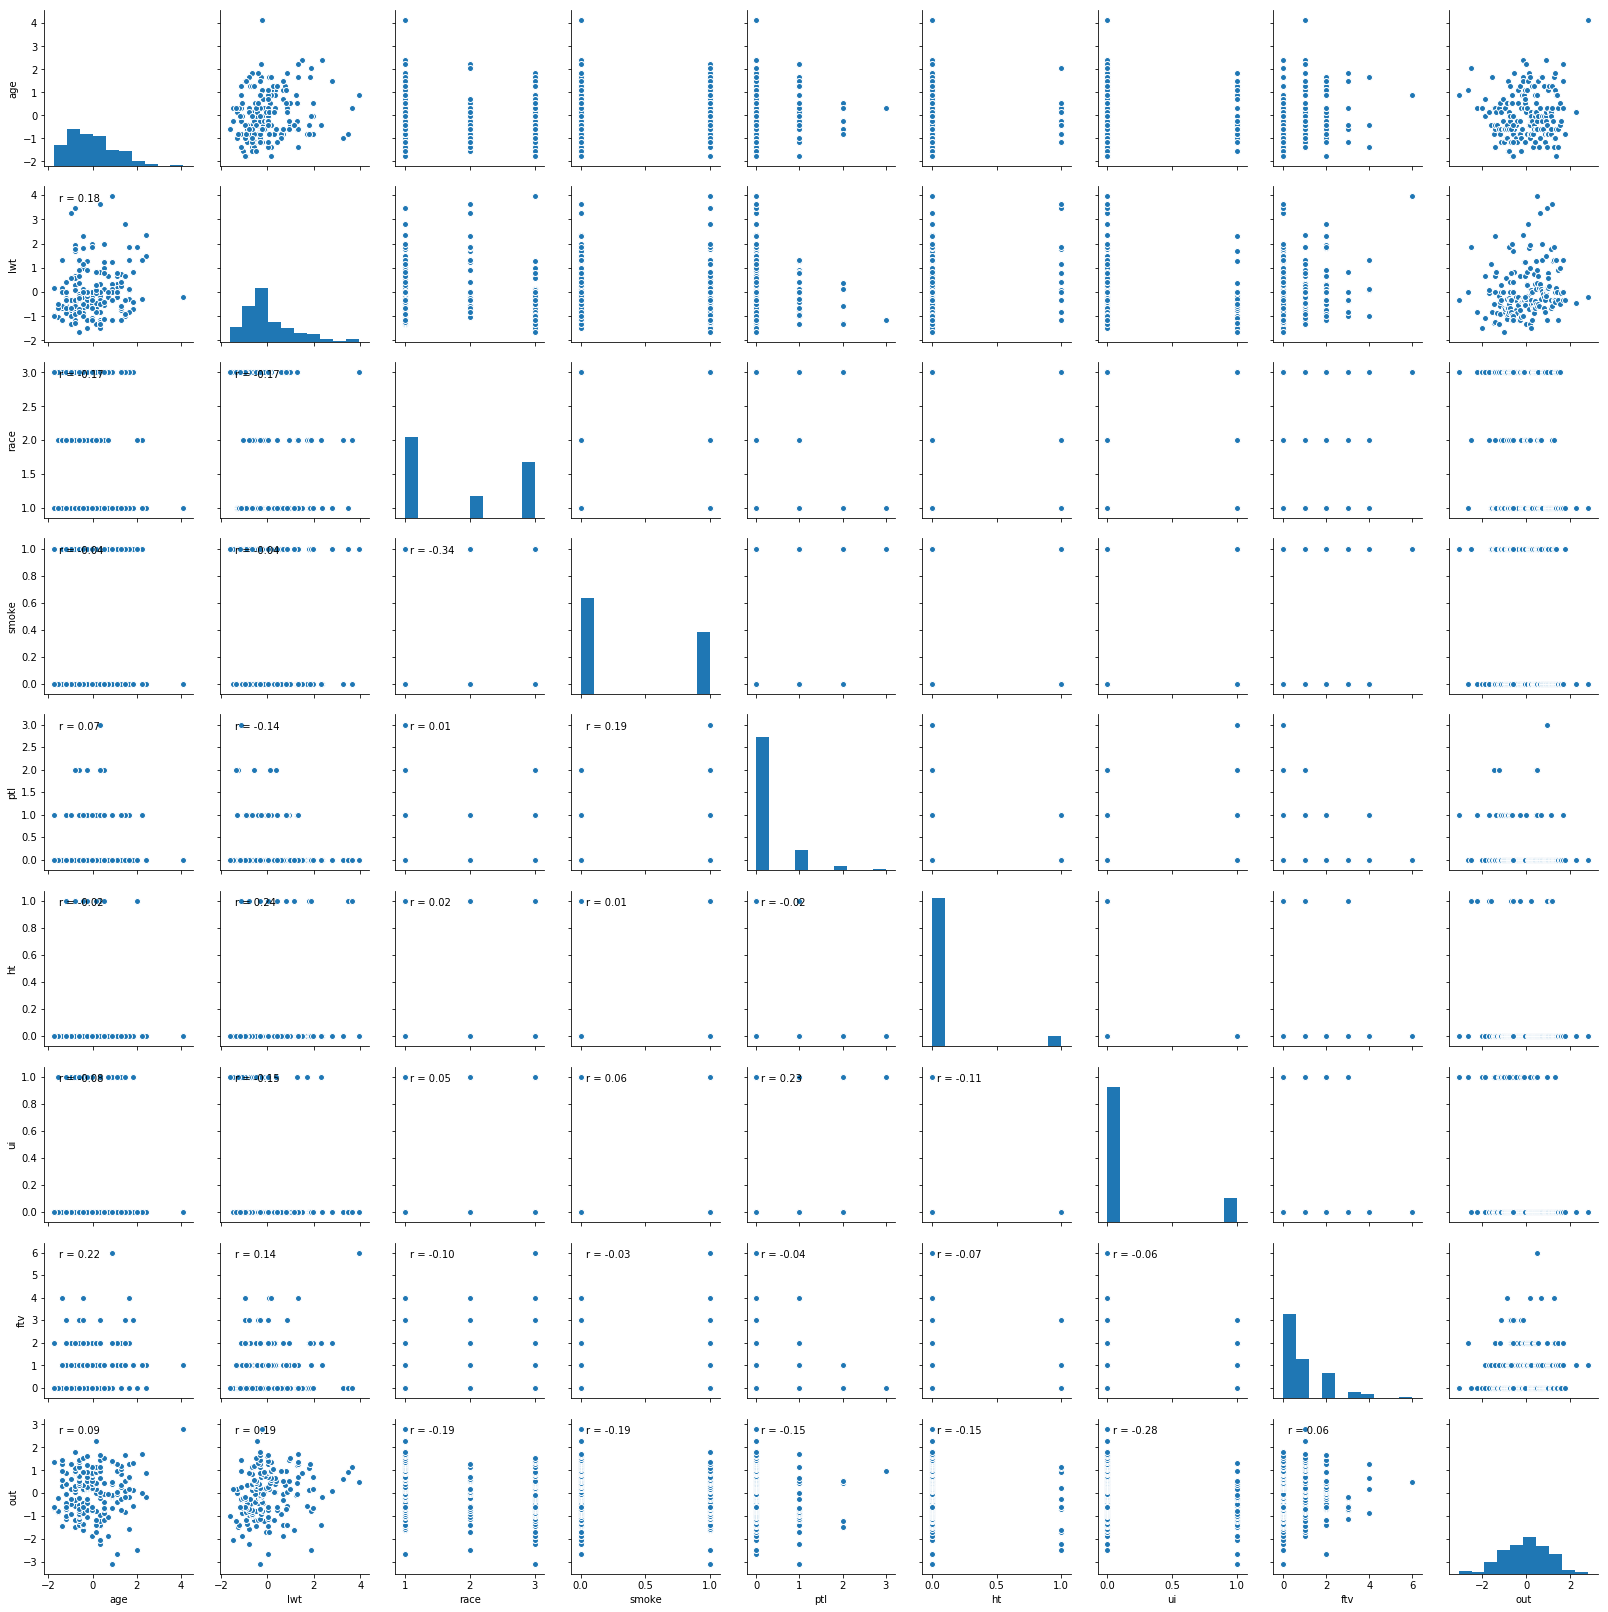

In [30]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']))
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0062
alpha: 0.0032 acc: 0.07 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0041 acc: 0.07 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0054 acc: 0.08 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0070 acc: 0.08 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0091 acc: 0.08 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0118 acc: 0.08 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0154 acc: 0.08 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0200 acc: 0.08 / 0.07 (unbiased) active_coefs: 8
alpha: 0.0261 acc: 0.07 / 0.08 (unbiased) active_coefs: 8
alpha: 0.0340 acc: 0.05 / 0.06 (unbiased) active_coefs: 8
alpha: 0.0442 acc: 0.04 / 0.03 (unbiased) active_coefs: 8
alpha: 0.0576 acc: 0.03 / 0.05 (unbiased) active_coefs: 7
alpha: 0.0750 acc: -0.00 / 0.06 (unbiased) active_coefs: 6
alpha: 0.0976 acc: -0.04 / -0.05 (unbiased) active_coefs: 5
alpha: 0.1271 acc: -0.05 / -0.04 (unbiased) active_coefs: 3
alpha: 0.1655 acc: -0.07 / -0.08 (unbiased) active_coefs: 2
alpha: 0.2154 acc: -0.06 / -0.04 (u

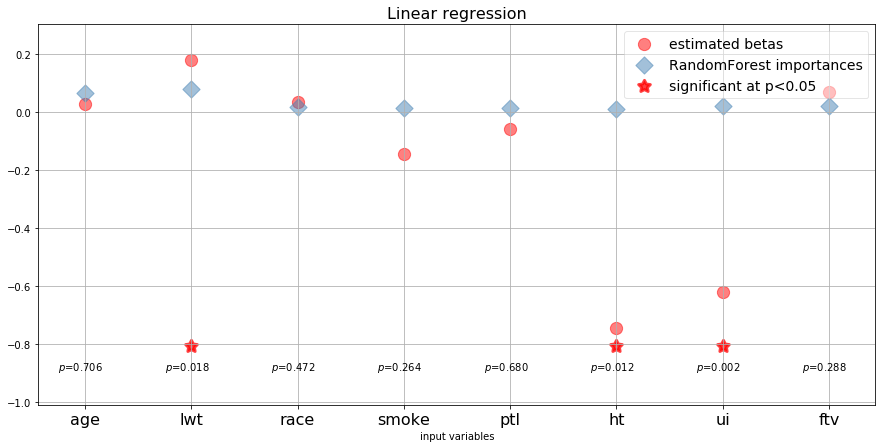

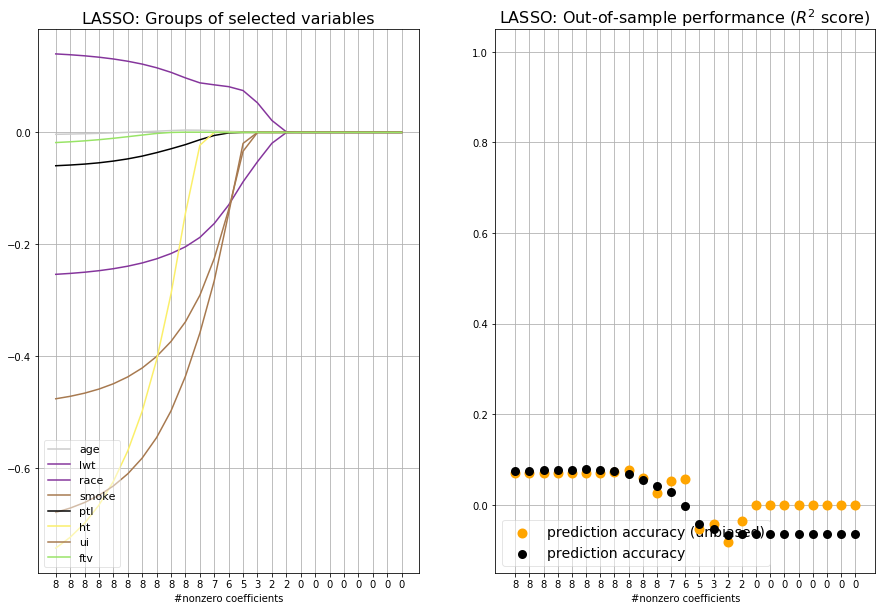

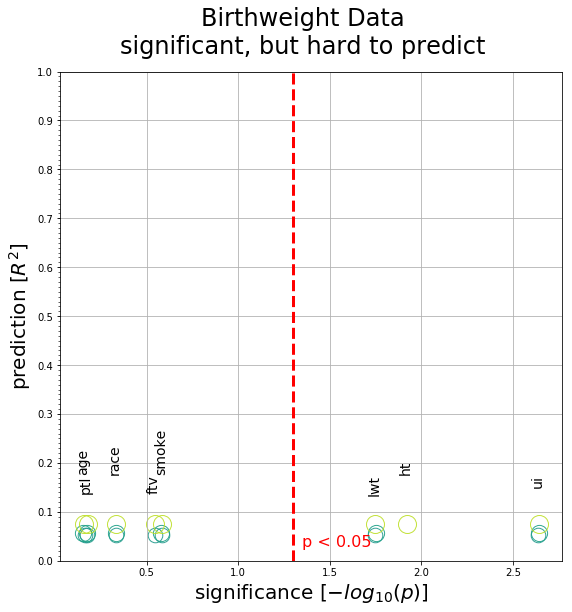

In [31]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-2.5, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
path_colors = plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)


fig = infpred_plot(unbiased_acc_list, lr_pvalues, coef_list, feat_names)
fig.suptitle('Birthweight Data\nsignificant, but hard to predict',
             fontsize=24, fontweight=150)
fig.savefig('reg-case4.pdf', bbox_inches='tight')


array(['#CCCCCC', '#85359C', '#85359C', '#A7794F', '#000000', '#FBEF69',
       '#A7794F', '#98E466'],
      dtype='<U7')

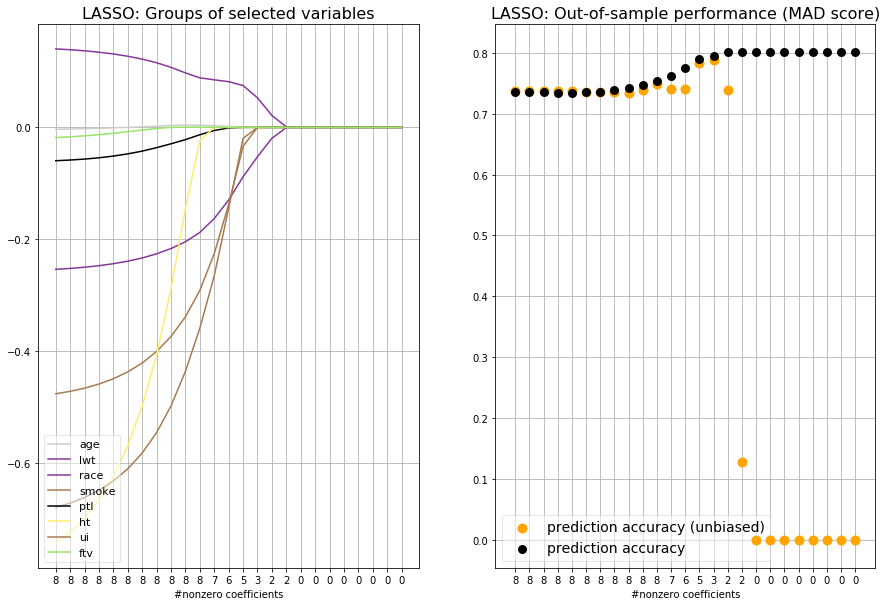

In [32]:
C_grid = np.logspace(-2.5, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid, metric=mean_absolute_error, verbose=False)
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list, metric=mean_absolute_error)

In [33]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  ui                             with p-value 7.51844e-05
Add  race                           with p-value 0.0099902
Add  smoke                          with p-value 0.000239631
Add  ht                             with p-value 0.01275
Add  lwt                            with p-value 0.038581
Add  ptl                            with p-value 0.614145
Add  ftv                            with p-value 0.732379
Add  age                            with p-value 0.977929
Forward-stepwise selection: ui -> race -> smoke -> ht -> lwt -> ptl -> ftv -> age


# conclusion:
- significant, but challenging to predict (10% population variance)
- not explained by sample size that is relatively low (n=189)
- 3/8 input variables significant, but 7/8 necessary for low R=0.1 accuracy
- in CS, also the in-sample R^2 score is bad (!): 0.141
- It is an example that significance offers only weak insight on predictability -> we are missing additional information

In [34]:
res.summary(xname=feat_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.724
Date:                Sun, 20 May 2018   Prob (F-statistic):           0.000468
Time:                        17:30:11   Log-Likelihood:                -253.78
No. Observations:                 189   AIC:                             523.6
Df Residuals:                     181   BIC:                             549.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0275      0.073      0.378      0.706      -0.116       0.171
lwt            0.1773      0.074      2.387      0.018       0.031       0.324
race           0.0322      0.045      0.721      0.472      -0.056       0.120
smoke         -0.1462      0.130     -1.120      0.264      -0.404       0.111
ptl           -0.0613      0.148     -0.413      0.680      -0.354       0.232
ht            -0.7446      0.294     -2.534      0.012      -1.325      -0.165
ui            -0.6217      0.201     -3.089      0.002      -1.019      -0.225
ftv            0.0683      0.064      1.065      0.288      -0.058       0.195
==============================================================================
Omnibus:                        0.618   Durbin-Watson:                   0.417
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.748
Skew:                          -0.080   Prob(JB):                        0.688
Kurtosis:                       2.737   Cond. No.                         9.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Additional Excericse: Primary biliary cirrhosis

In [35]:
import pandas as pd
df_cir = pd.read_excel('sources_medical_datasets/_Mayo_Clinic_primary_biliary_cirrhosis_pbc.xls')


*** No CODEPAGE record, no encoding_override: will use 'ascii'


In [36]:
df_cir

,bili,albumin,stage,protime,sex,fu.days,age,spiders,hepatom,ascites,alk.phos,sgot,chol,trig,platelet,drug,status,edema,copper
0,14.500000,2.60,4.0,12.2,female,400,58.765228,present,present,present,1718.000000,137.949997,261.0,172.0,190.0,placebo,1,edema despite diuretic therapy,156.0
1,1.100000,4.14,3.0,10.6,female,4500,56.446270,present,present,absent,7394.799805,113.519997,302.0,88.0,221.0,placebo,0,no edema,54.0
2,1.400000,3.48,4.0,12.0,male,1012,70.072556,absent,absent,absent,516.000000,96.099998,176.0,55.0,151.0,placebo,1,"edema, no diuretic therapy",210.0
3,1.800000,2.54,4.0,10.3,female,1925,54.740589,present,present,absent,6121.799805,60.630001,244.0,92.0,183.0,placebo,1,"edema, no diuretic therapy",64.0
4,3.400000,3.53,3.0,10.9,female,1504,38.105408,present,present,absent,671.000000,113.150002,279.0,72.0,136.0,D-penicillamine,0,no edema,143.0
5,0.800000,3.98,3.0,11.0,female,2503,66.258728,absent,present,absent,944.000000,93.000000,248.0,63.0,NaN,D-penicillamine,1,no edema,50.0
6,1.000000,4.09,3.0,9.7,female,1832,55.534565,absent,present,absent,824.000000,60.450001,322.0,213.0,204.0,D-penicillamine,0,no edema,52.0
7,0.300000,4.00,3.0,11.0,female,2466,53.056812,absent,absent,absent,4651.200195,28.379999,280.0,189.0,373.0,D-penicillamine,1,no edema,52.0
8,3.200000,3.08,2.0,11.0,female,2400,42.507870,present,absent,absent,2276.000000,144.149994,562.0,88.0,251.0,placebo,1,no edema,79.0
9,12.600000,2.74,4.0,11.5,female,51,70.559891,present,absent,present,918.000000,147.250000,200.0,143.0,302.0,D-penicillamine,1,edema despite diuretic therapy,140.0
